In [ ]:
import numpy as np
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):

        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [ ]:
import numpy as np
from collections import Counter

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        # Initialize the DecisionTree with specified parameters



        self.min_samples_split = min_samples_split# min_samples_split: minimum number of samples required to split a node
        self.max_depth = max_depth# max_depth: maximum depth of the tree
        self.n_features = n_features  # n_features: number of features to consider when looking for the best split
        self.root = None  # Root of the decision tree

    def fit(self, X, y):
        # Fit the decision tree to the training data
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        # Recursively grow the decision tree by splitting nodes
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # Check stopping criteria: maximum depth, pure node, or not enough samples
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            class_probs = np.bincount(y.astype(int), minlength=n_labels) / len(y)
            print(f"Leaf node: value={leaf_value}, class_probs={class_probs}")
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # Find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)
        information_gain = self._information_gain(y, X[:, best_feature], best_thresh)
        print(f"Node: feature={best_feature}, threshold={best_thresh}, information_gain={information_gain}")

        # Create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        # Find the best split for a subset of features
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # Calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        # Calculate information gain for a split
        parent_entropy = self._entropy(y)

        # Create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # Calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        # Split the data based on a threshold
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        # Calculate entropy of a set of labels
        y = np.round(y).astype(int)
        hist = np.bincount(y)
        ps = hist / len(y)
        return float(-np.sum([p * np.log(p) for p in ps if p > 0]))

    def _most_common_label(self, y):
        # Find the most common label in a set of labels
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        # Predict labels for input data
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        # Traverse the decision tree to find the predicted label for a given input
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


In [ ]:
import numpy as np
from collections import Counter

class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        # Initialize the RandomForest with specified parameters
        # n_trees: number of decision trees in the random forest
        # max_depth: maximum depth of each decision tree
        # min_samples_split: minimum number of samples required to split a node in each tree
        # n_feature: number of features to consider when looking for the best split in each tree
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_feature
        self.trees = []  # List to store the individual decision trees

    def fit(self, X, y):
        # Fit the random forest to the training data
        self.trees = []
        for _ in range(self.n_trees):
            # Create a decision tree and fit it to a bootstrap sample of the data
            tree = DecisionTree(max_depth=self.max_depth,
                                min_samples_split=self.min_samples_split,
                                n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)  # Add the trained tree to the list

    def _bootstrap_samples(self, X, y):
        # Generate a bootstrap sample from the training data
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        # Find the most common label in a set of labels
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        # Make predictions using the random forest
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        # For each set of predictions from the trees, choose the most common label
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions


In [ ]:
#XOR DATASET

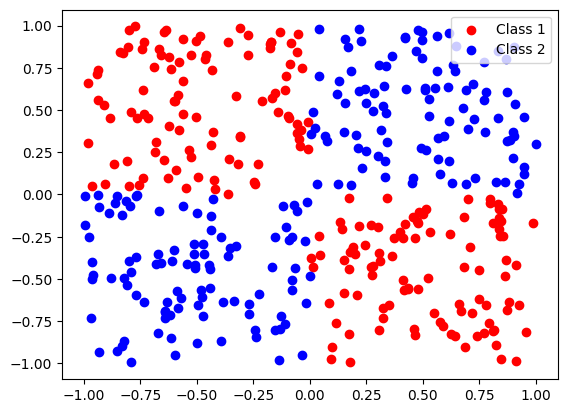

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate points for Class 1
x1 = np.concatenate([np.random.uniform(0, 1, 100), np.random.uniform(-1, 0, 100)])
y1 = np.concatenate([np.random.uniform(-1, 0, 100), np.random.uniform(0, 1, 100)])
label1 = np.zeros_like(x1)  # create an array of zeros of the same shape as x1 and y1

# Generate points for Class 2
x2 = np.concatenate([np.random.uniform(0, 1, 100), np.random.uniform(-1, 0, 100)])
y2 = np.concatenate([np.random.uniform(0, 1, 100), np.random.uniform(-1, 0, 100)])
label2 = np.ones_like(x2)  # create an array of ones of the same shape as x2 and y2


plt.scatter(x1, y1, c='red', label='Class 1')
plt.scatter(x2, y2, c='blue', label='Class 2')


plt.legend()
plt.show()


In [ ]:
# Merge data and labels
X = np.concatenate((np.column_stack((x1, y1)), np.column_stack((x2, y2))))
y = np.concatenate((label1, label2))

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [ ]:
clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

Node: feature=1, threshold=-0.6501673243990033, information_gain=0.016045280443656496
Node: feature=0, threshold=-0.005755354113604616, information_gain=0.6365141682948128
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=0, threshold=-0.10190569160935192, information_gain=0.03729345971497566
Node: feature=1, threshold=-0.0027955199697449196, information_gain=0.6772976974986347
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=1, threshold=-0.00667548774858695, information_gain=0.2887174973719976
Node: feature=0, threshold=-0.015264653435176911, information_gain=0.5074299622199485
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=0, threshold=-0.0013625382164328403, information_gain=0.24730106105036703
Leaf node: value=0.0, class_probs=[1.]
Leaf node: value=1.0, class_probs=[0. 1.]


In [ ]:
#accuracy for decision tree
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)

0.9916666666666667

In [ ]:
#accuracy for random forest
clf = RandomForest(n_trees=10)
clf.fit(X_train, y_train)
rpredictions = clf.predict(X_test)

Node: feature=1, threshold=-0.5733108819779892, information_gain=0.015257776874051276
Node: feature=0, threshold=-0.021988191121528167, information_gain=0.6365141682948128
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=0, threshold=-0.5558224738160789, information_gain=0.05706466406974353
Node: feature=1, threshold=-0.02231246917732188, information_gain=0.5672739606962847
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=1, threshold=0.1291448111911503, information_gain=0.0549861196024477
Node: feature=0, threshold=-0.09708960342670192, information_gain=0.4896298532024074
Node: feature=1, threshold=-0.03077247941111827, information_gain=0.21028341228613337
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=1, threshold=-0.00667548774858695, information_gain=0.10176027231540595
Leaf node: value=0.0, class_probs=[1.]
Node: feature=1, threshold=0.0570877

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,rpredictions)

0.9916666666666667

In [ ]:
#boundary visualisation
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    X_mesh = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(X_mesh.reshape(-1, 2))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(-0.5, 2, 1))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors='black')


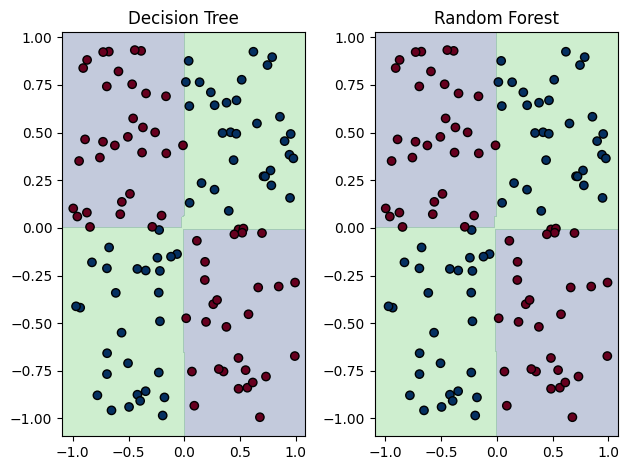

In [ ]:
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, X_test, y_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, X_test, y_test)
plt.tight_layout()
plt.show()


DATA SET FOR CONCENTRIC CIRCLES

Generate a three-class concentric circles dataset with 300 samples in total (100 per class) and a certain amount of Gaussian noise. The circles are centered at (0, 0), (0, 0), and (0,0), respectively, with radii of 1, 2, and 3.
The X array holds the data points and the y array holds the corresponding class labels, with class 0 denoted by blue points, class 1 denoted by
green points, and class 2 denoted by red points

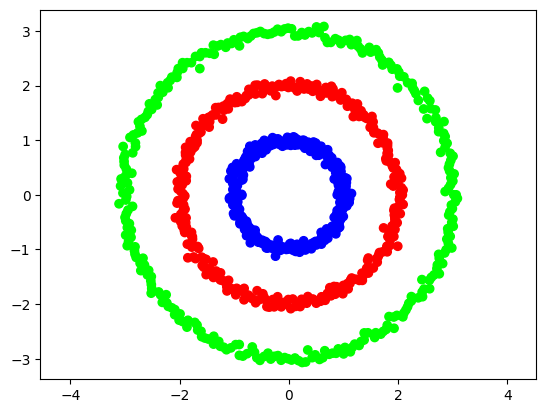

In [ ]:

# Set the number of samples and noise level
n = 300
noise = 0.06

# Generate the data
theta = np . linspace (0 , 2* np . pi , n )
r1 = np . random . normal (0 , noise , n ) + 1
r2 = np . random . normal (0 , noise , n ) + 2
r3 = np . random . normal (0 , noise , n ) + 3
x1 = r1 * np . cos ( theta )
y1 = r1 * np . sin ( theta )
x2 = r2 * np . cos ( theta )
y2 = r2 * np . sin ( theta )
x3 = r3 * np . cos ( theta )
y3 = r3 * np . sin ( theta )
# Concatenate the data and labels
X = np . concatenate ([ np . vstack ([ x1 , y1 ]) , np . vstack ([ x2 , y2 ]) , np . vstack ([ x3 , y3]) ] , axis =1)
y = np.concatenate([np.zeros(n),np.ones(n),np.full(n,2)])
# Plot the data
plt.scatter(X[0,:],X[1,:],c=y,cmap = plt.cm.brg )
plt.axis('equal')
plt.show()


In [ ]:
X

array([[ 1.06334795e+00,  1.14543686e+00,  1.07310177e+00, ...,
         3.04651807e+00,  3.08442515e+00,  3.06252879e+00],
       [ 0.00000000e+00,  2.40737512e-02,  4.51268893e-02, ...,
        -1.28114488e-01, -6.48256453e-02, -7.50103215e-16]])

In [ ]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
a = np.concatenate([np.vstack([x1, y1]), np.vstack([x2, y2]), np.vstack([x3, y3])], axis=1)
b = np.concatenate([np.zeros(n), np.ones(n), np.full(n, 2)])
a_train, a_test, b_train, b_test = train_test_split(a.T, b, test_size=0.3)

In [ ]:
clf = DecisionTree(max_depth=10)
clf.fit(a_train, b_train)
predictions = clf.predict(a_test)

Node: feature=1, threshold=-1.1376490507638286, information_gain=0.11333362067335828
Node: feature=1, threshold=-2.1621537349903854, information_gain=0.3183623663748069
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-2.1455983217647434, information_gain=0.23945640262369577
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=0, threshold=1.6297880531554134, information_gain=0.41631014066777594
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=1, threshold=1.0609703028266113, information_gain=0.22806171435506817
Node: feature=0, threshold=1.1454368617633475, information_gain=0.25295589604368196
Node: feature=0, threshold=-1.6523349312107825, information_gain=0.5313388614561229
Node: feature=0, threshold=-2.8086073057423584, information_gain=0.6744087274254286
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=0, thresh

In [ ]:
#accuracy for decision tree
accuracy_score(b_test,predictions)

0.9851851851851852

In [ ]:
#accuracy or random forest
clf = RandomForest(n_trees=10)
clf.fit(a_train, b_train)
predictions = clf.predict(a_test)

Node: feature=1, threshold=2.0718229513464834, information_gain=0.11139637615067277
Node: feature=1, threshold=-2.0681110695281175, information_gain=0.14695752086297054
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=0, threshold=2.0907946440859018, information_gain=0.2064653956064303
Node: feature=0, threshold=-2.2481939264382267, information_gain=0.2952203073740728
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-1.086409894400557, information_gain=0.13887266526805953
Leaf node: value=1.0, class_probs=[0. 1.]
Node: feature=0, threshold=1.1111898059246343, information_gain=0.24361821914095871
Node: feature=1, threshold=1.0180547553795647, information_gain=0.22160690302003772
Node: feature=1, threshold=-1.6249874623636384, information_gain=0.411262472596901
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Leaf node: value=1.0, class_probs=[0. 1.]
Node: feature=1, threshold=1.6638562319819286, information_gain=0.06859321

In [ ]:
accuracy_score(b_test, predictions)

0.9851851851851852

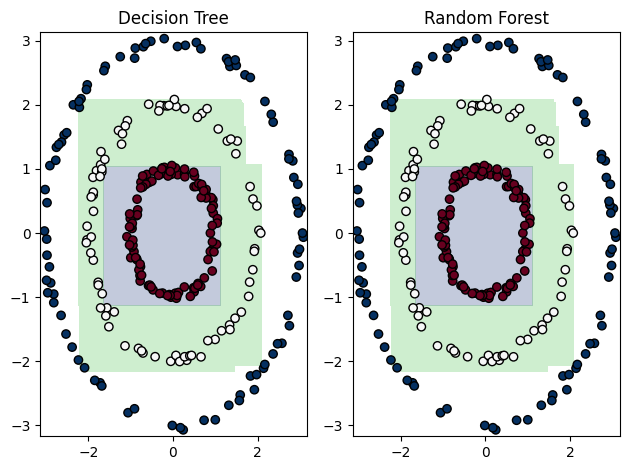

In [ ]:
#Boundary Visualization
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, a_test, b_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, a_test, b_test)
plt.tight_layout()
plt.show()

Unbalanced Spiral dataset

 Generate a 2D dataset consisting of 3 classes arranged in a spiral pattern. The dataset
has a total of 600 points, with 200 points per class. The variable X is a matrix of size 600x2,
where each row represents a data point in 2D space. The variable y is a vector of size 600, where
each element represents the class label (0, 1, or 2) of the corresponding data point in X.

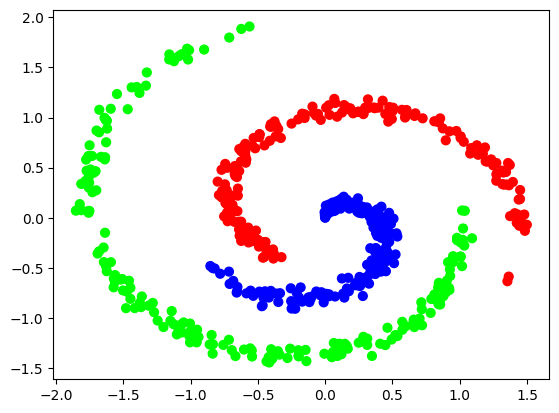

In [ ]:

N = 200 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix ( each row = single example )
y = np.zeros(N*K,dtype='uint8') # class labels
for j in range (K):
    ix = range (N*j,N*(j+1))
    r = np.linspace (0.0,1,N) # radius
    r = r+j*0.5
    t = np.linspace(j*4,(j+1)*4,N)+np.random.randn(N)*0.2 # theta
    X[ix]=np.c_[r*np.sin(t),r*np.cos(t)]
    y[ix]=j
spiral4 = np.column_stack((X,y))
plt.scatter(X[:,0],X[:,1],c=y,s=40,cmap='brg')
plt.show()


In [ ]:
# Accuracy for Decision Tree
C_train, C_test, D_train, D_test = train_test_split(X,y, test_size=0.3)
clf = DecisionTree(max_depth=5)
clf.fit(C_train, D_train)
predictions = clf.predict(C_test)

Node: feature=0, threshold=-0.8584366329593122, information_gain=0.21624498346923826
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=1, threshold=0.21026402301201572, information_gain=0.3033024201871507
Node: feature=1, threshold=-0.9120199920929583, information_gain=0.2547460742230395
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=0.5361292236942912, information_gain=0.3602518739878239
Node: feature=0, threshold=-0.32491885222763744, information_gain=0.31388378753963775
Leaf node: value=1, class_probs=[0.33898305 0.66101695]
Leaf node: value=0, class_probs=[1.]
Node: feature=0, threshold=1.0245888910298204, information_gain=0.5220770639132397
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=1, threshold=1.1865092304273785, information_gain=0.10210797344924928
Leaf node: value=1, class_probs=[0. 1.]
Leaf node: value=2, class_probs=[0. 0. 1.]


In [ ]:
accuracy_score(D_test,predictions)

0.9444444444444444

In [ ]:
#accuracy for random forest
clf = RandomForest(n_trees=10)
clf.fit(C_train, D_train)
predictions = clf.predict(C_test)

Node: feature=1, threshold=0.21026402301201572, information_gain=0.24426239450608156
Node: feature=1, threshold=-0.9120199920929583, information_gain=0.22472045332112267
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-1.368479630739478, information_gain=0.1886877509417123
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=0.5361292236942912, information_gain=0.31180665813316777
Node: feature=0, threshold=-0.32491885222763744, information_gain=0.2997942300823701
Node: feature=1, threshold=-0.502611654422949, information_gain=0.6510417615024222
Leaf node: value=0, class_probs=[1.]
Leaf node: value=1, class_probs=[0. 1.]
Leaf node: value=0, class_probs=[1.]
Node: feature=0, threshold=1.0245888910298204, information_gain=0.5941300227248385
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=0, threshold=-0.8998008275860188, information_gain=0.4588266408015071
Leaf node: value=2, class_probs=[0. 0. 1.]
No

In [ ]:
accuracy_score(D_test,predictions)

0.9722222222222222

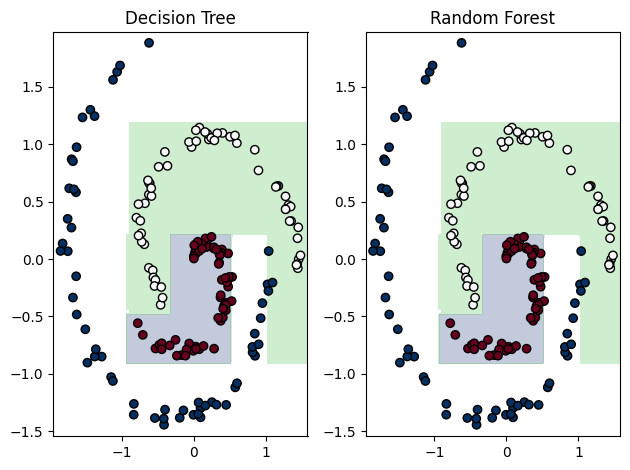

In [ ]:
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, C_test, D_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, C_test, D_test)
plt.tight_layout()
plt.show()

**Balanced Spiral**
The dataset has the same number of points and classes as before, but the radius increment for
each class is now smaller

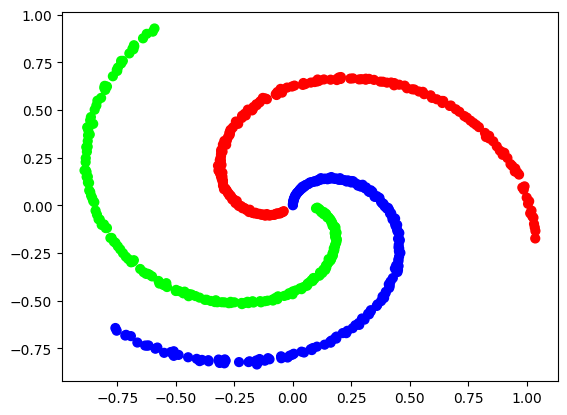

In [ ]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np . zeros (( N *K , D ) ) # data matrix ( each row = single example )
y = np . zeros ( N *K , dtype ='uint8') # class labels
for j in range ( K ) :
    ix = range (N *j , N *( j +1) )
    r = np . linspace (0.0 ,1 , N ) # radius
    r = r + j *0.05
    # print (r)
    t = np . linspace ( j *4 ,( j +1) *4 , N ) + np . random . randn ( N ) *0.02 # theta
    # print (t)
    X [ ix ] = np . c_ [ r * np . sin ( t ) , r * np . cos ( t ) ]
    y [ ix ] = j
spiral5 = np . column_stack (( X , y ) )
np . savetxt ("spiral3u.csv", spiral5 , delimiter =",", header ="x,y,label", comments
="", fmt ='%.5f')
plt . scatter ( X [: , 0] , X [: , 1] , c =y , s =40 , cmap ='brg')
plt . show ()

In [ ]:
#Accuracy for Decision Tree
A_train, A_test, b_train, b_test = train_test_split(X,y, test_size=0.3)
clf = DecisionTree(max_depth=5)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=1, threshold=0.1488075951741606, information_gain=0.21682433304860516
Node: feature=0, threshold=0.18763099050826326, information_gain=0.16657280292463406
Node: feature=1, threshold=-0.6579049244663159, information_gain=0.23120532185273523
Leaf node: value=0, class_probs=[1.]
Node: feature=1, threshold=-0.06334656747125823, information_gain=0.4251791156094462
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-0.03927630578085281, information_gain=0.5577961771062785
Leaf node: value=1, class_probs=[0.         0.79166667 0.20833333]
Leaf node: value=0, class_probs=[0.81818182 0.         0.18181818]
Node: feature=0, threshold=0.45925577085073715, information_gain=0.3306806308319787
Leaf node: value=0, class_probs=[1.]
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=0, threshold=-0.5915265851043771, information_gain=0.5754438380175589
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=1, class_probs=[0. 1.]


In [ ]:
accuracy_score(b_test,predictions)

0.9666666666666667

In [ ]:
#Accuracy for Random Forest
clf = RandomForest(n_trees=10)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=1, threshold=0.1488075951741606, information_gain=0.2238913026220708
Node: feature=0, threshold=0.18763099050826326, information_gain=0.19051950630057046
Node: feature=1, threshold=-0.6796286216320493, information_gain=0.23470452278633436
Leaf node: value=0, class_probs=[1.]
Node: feature=1, threshold=-0.06948852722057079, information_gain=0.3936404917327099
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-0.03927630578085281, information_gain=0.5310752537440853
Node: feature=0, threshold=-0.8372484875732809, information_gain=0.5098156995816887
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=1, threshold=-0.012340583987783826, information_gain=0.5146531654289292
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=0, class_probs=[1.]
Node: feature=0, threshold=0.455212799347452, information_gain=0.3094772867741259
Leaf node: value=0, class_probs=[1.]
Leaf node: value=1, class_probs=[0. 1.]
Node:

In [ ]:
accuracy_score(b_test,predictions)

0.9944444444444445

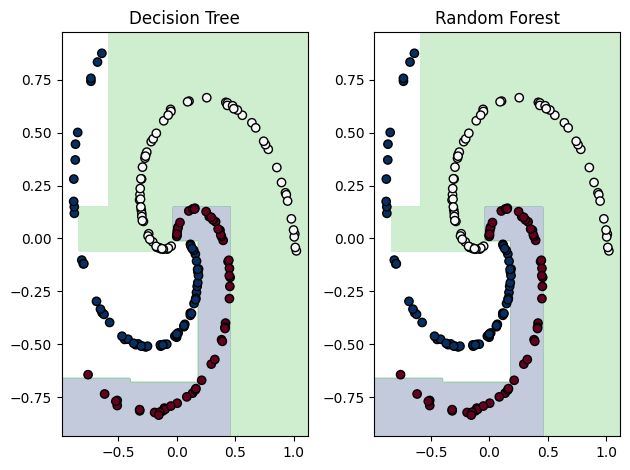

In [ ]:
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, A_test, b_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, A_test, b_test)
plt.tight_layout()
plt.show()

5 Class dataset

**Unbalanced Spiral**
Generate a 2D dataset consisting of 5 classes arranged in a spiral pattern. The dataset
has a total of 1000 points, with 200 points per class

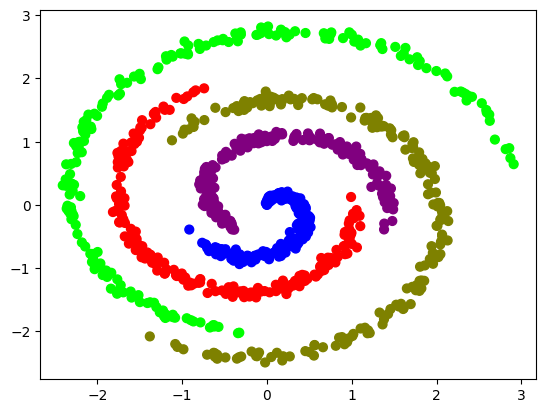

In [ ]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 5 # number of classes
X = np . zeros (( N *K , D ) ) # data matrix ( each row = single example )
y = np . zeros ( N *K , dtype ='uint8') # class labels
for j in range ( K ) :
    ix = range (N *j , N *( j +1) )
    r = np . linspace (0.0 ,1 , N ) # radius
    r = r + j *0.5
    t = np.linspace(j *4 ,( j +1) *4 , N ) + np . random . randn ( N ) *0.2 # theta
    # print (t)
    X [ ix ] = np.c_[r*np.sin(t),r*np.cos(t)]
    y [ ix ] = j
spiral4 = np.column_stack((X,y))
plt.scatter(X[:,0],X[:,1],c=y,s=40,cmap ='brg')
plt.show()


In [ ]:
A_train, A_test, b_train, b_test = train_test_split(X,y, test_size=0.3)
clf = DecisionTree(max_depth=5)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=0, threshold=-0.7836795021935679, information_gain=0.21661664098083588
Node: feature=0, threshold=-1.839693901745374, information_gain=0.23306751145181615
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=1, threshold=1.779532511277382, information_gain=0.2016582623985278
Node: feature=1, threshold=-1.3528317362776396, information_gain=0.35468501870270164
Node: feature=1, threshold=-2.077948467239982, information_gain=0.410116318288409
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=0, threshold=-1.1465621298224782, information_gain=0.1474941537221146
Leaf node: value=2, class_probs=[0.         0.         0.92982456 0.         0.07017544]
Leaf node: value=2, class_probs=[0.05 0.   0.65 0.3 ]
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=1, threshold=0.20994502320229944, information_gain=0.2908403762630092
Node: feature=1, threshold=-0.9093002802269081, information_gain=0.32808669488

In [ ]:
accuracy_score(b_test,predictions)

0.9333333333333333

In [ ]:
#Accuracy for random forest
clf = RandomForest(n_trees=10)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=0, threshold=-0.7836795021935679, information_gain=0.2569985502452652
Node: feature=0, threshold=-1.839693901745374, information_gain=0.23346412145757434
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=1, threshold=1.7143677381469855, information_gain=0.22857179718254483
Node: feature=1, threshold=-1.268791131650185, information_gain=0.4630569172321277
Node: feature=1, threshold=-2.077948467239982, information_gain=0.2868359830561607
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=0, threshold=-1.1465621298224782, information_gain=0.15106395283419105
Node: feature=1, threshold=-1.1766364950128028, information_gain=0.08151041095033153
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=1, threshold=-1.0259856537180851, information_gain=0.4778499455562672
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=1, threshold=1.3129149019774913, in

In [ ]:
accuracy_score(b_test,predictions)

0.97

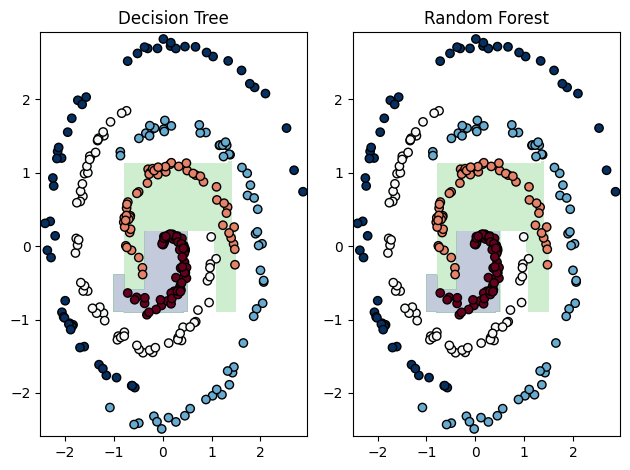

In [ ]:
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, A_test, b_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, A_test, b_test)
plt.tight_layout()
plt.show()

**Balanced Spiral**
This code generates a 2D dataset consisting of 5 classes arranged in a spiral pattern. The dataset
has a total of 1000 points, with 200 points per class.

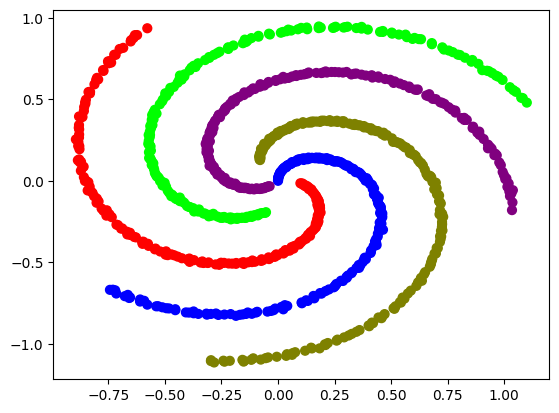

In [ ]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 5 # number of classes
X = np . zeros (( N *K , D ) ) # data matrix ( each row = single example )
y = np . zeros ( N *K , dtype ='uint8') # class labels
for j in range ( K ) :
    ix = range (N *j , N *( j +1) )
    r = np . linspace (0.0 ,1 , N ) # radius
    r = r + j *0.05
    # print (r)
    t = np . linspace ( j *4 ,( j +1) *4 , N ) + np . random . randn ( N ) *0.02 # theta
    # print (t)
    X [ ix ] = np . c_ [ r * np . sin ( t ) , r * np . cos ( t ) ]
    y [ ix ] = j
spiral5 = np . column_stack (( X , y ) )
plt . scatter ( X [: , 0] , X [: , 1] , c =y , s =40 , cmap ='brg')
plt . show ()

In [ ]:
A_train, A_test, b_train, b_test = train_test_split(X,y, test_size=0.3)
clf = DecisionTree(max_depth=5)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=1, threshold=-0.2396125108107958, information_gain=0.17782766051598986
Node: feature=1, threshold=-0.5168143592642835, information_gain=0.3577455322650276
Node: feature=1, threshold=-0.8362130687127498, information_gain=0.33138792756399893
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=0.3640123916205615, information_gain=0.4839030795513415
Leaf node: value=0, class_probs=[1.]
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=0.17854761578758788, information_gain=0.5913886864871765
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=0.4641019731834674, information_gain=0.6759010305740114
Leaf node: value=0, class_probs=[1.]
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=-0.32265589633958325, information_gain=0.23204708209409208
Node: feature=0, threshold=-0.5780181672625783, information_gain=0.6786591340630184
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=4, class_pr

In [ ]:
accuracy_score(b_test,predictions)

0.8733333333333333

In [ ]:
clf = RandomForest(n_trees=10)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=1, threshold=-0.2396125108107958, information_gain=0.18524240674598702
Node: feature=1, threshold=-0.5180675109910647, information_gain=0.3468594969936174
Node: feature=1, threshold=-0.8700882912089482, information_gain=0.27426070331096664
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=0.3640123916205615, information_gain=0.49356519202546545
Leaf node: value=0, class_probs=[1.]
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=0.17854761578758788, information_gain=0.6108643020548935
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=0.45725226589817786, information_gain=0.5799151714181009
Leaf node: value=0, class_probs=[1.]
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=-0.08244055288402297, information_gain=0.23803691565514584
Node: feature=0, threshold=-0.5780181672625783, information_gain=0.48523601892232715
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshol

In [ ]:
accuracy_score(b_test,predictions)

0.9866666666666667

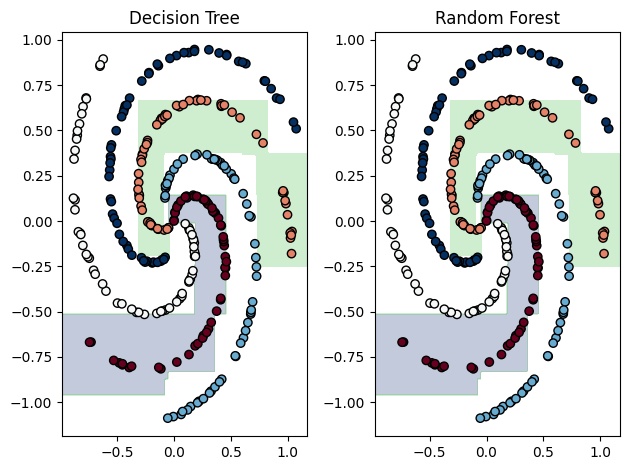

In [ ]:
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, A_test, b_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, A_test, b_test)
plt.tight_layout()
plt.show()